In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# how much do we expect to improve from 10x the cells?
df = pd.read_csv('collect_mi_results.csv')
res_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
res_df = res_df[(res_df['metric'] != 'celltype.l3') & (res_df['quality'] == 1)]
res_df

,dataset,method,metric,quality,N0,s,I_inf,I_0,mean_residual
19,PBMC,Geneformer,protein_counts,1.0,4561.610,1.999,3.620,1.697,0.585
39,PBMC,PCA,protein_counts,1.0,20416.934,0.490,4.400,3.573,0.197
59,PBMC,RandomProjection,protein_counts,1.0,15583.450,0.446,2.930,2.705,0.110
79,PBMC,SCVI,protein_counts,1.0,4951.539,1.435,4.768,2.515,0.352
89,larry,Geneformer,clone,1.0,170.391,0.849,1.070,0.032,0.157
99,larry,PCA,clone,1.0,65172.763,0.964,1.839,1.318,0.137
109,larry,RandomProjection,clone,1.0,21733.759,0.502,0.525,0.350,0.000
119,larry,SCVI,clone,1.0,416.300,1.007,1.768,0.671,0.095
129,merfish,Geneformer,ng_idx,1.0,135.075,0.523,1.304,0.419,0.088
139,merfish,PCA,ng_idx,1.0,43505.377,0.858,2.358,1.228,0.264


In [ ]:
def cell_number_scaling(x, N0, s, I_inf, I_0):
    """
    Cell number scaling function: I(x) = max(I_0, I_inf - (x / N0) ** (-s))
    """
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        # Calculate the scaling term more safely to avoid overflow
        ratio = x / N0
        # Use log-space calculation to avoid overflow
        scaling_term = np.where(
            ratio > 0,
            np.exp(-s * np.log(ratio)),
            0.0
        )
        result = np.where(x > 0, np.maximum(I_0, I_inf - scaling_term), np.nan)
    return result

In [4]:
d = {
    'dataset': [],
    'method': [],
    'metric': [],
    'I_max': [],
    'I_10x': [],
    'perc_increase': [],
    'bits increase': []
}
for row in res_df.itertuples():
    N0, s, I_inf, I_0 = row.N0, row.s, row.I_inf, row.I_0
    metric = row.metric
    dataset = row.dataset
    method = row.method

    max_cells = df[(df['dataset'] == dataset) & (df['algorithm'] == method) & (df['signal'] == metric)]['size'].max()
    cells_10x = max_cells * 10
    I_max = cell_number_scaling(max_cells, N0, s, I_inf, I_0)
    I_10x = cell_number_scaling(cells_10x, N0, s, I_inf, I_0)
    print(f"{dataset} {method} {metric}: {I_max:.3f} -> {I_10x:.3f} ({(I_10x - I_max) / I_max * 100:.1f}%)")

    # construct DataFrame
    d['dataset'].append(dataset)
    d['method'].append(method)
    d['metric'].append(metric)
    d['I_max'].append(I_max)
    d['I_10x'].append(I_10x)
    d['perc_increase'].append((I_10x - I_max) / I_max * 100)
    d['bits increase'].append(I_10x - I_max)

projection_df = pd.DataFrame(d)

PBMC Geneformer protein_counts: 3.618 -> 3.620 (0.1%)
PBMC PCA protein_counts: 3.941 -> 4.251 (7.9%)
PBMC RandomProjection protein_counts: 2.705 -> 2.774 (2.5%)
PBMC SCVI protein_counts: 4.755 -> 4.768 (0.3%)
larry Geneformer clone: 1.066 -> 1.069 (0.4%)
larry PCA clone: 1.318 -> 1.767 (34.1%)
larry RandomProjection clone: 0.350 -> 0.379 (8.2%)
larry SCVI clone: 1.764 -> 1.768 (0.2%)
merfish Geneformer ng_idx: 1.263 -> 1.292 (2.3%)
merfish PCA ng_idx: 1.599 -> 2.253 (40.9%)
merfish RandomProjection ng_idx: 0.485 -> 0.578 (19.2%)
merfish SCVI ng_idx: 1.975 -> 2.116 (7.1%)
shendure Geneformer author_day: 1.991 -> 1.998 (0.4%)
shendure PCA author_day: 1.167 -> 1.172 (0.4%)
shendure RandomProjection author_day: 0.622 -> 0.634 (1.9%)
shendure SCVI author_day: 2.376 -> 2.401 (1.0%)


mean projected increase
method
Geneformer           0.766407
PCA                 20.804521
RandomProjection     7.940831
SCVI                 2.162979
Name: perc_increase, dtype: float64


<Axes: xlabel='method', ylabel='metric'>

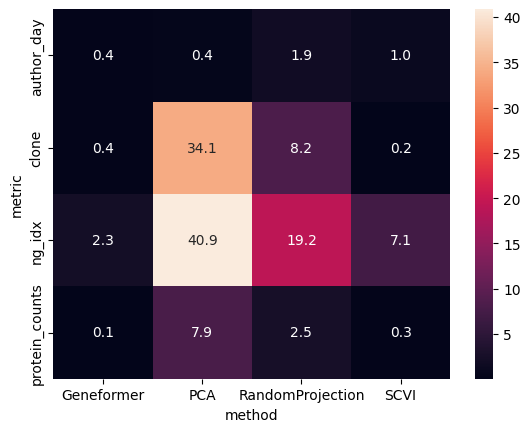

In [5]:
print('mean projected increase')
print(projection_df.groupby('method')['perc_increase'].mean())

# plot heatmap
sns.heatmap(pd.pivot_table(projection_df, values='perc_increase', 
                           index='metric', columns='method'), annot=True, fmt=".1f")

In [6]:
noise_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
noise_df = noise_df[(noise_df['metric'] != 'celltype.l3')]
noise_df = noise_df[noise_df['size'].isin(noise_df.groupby('dataset')['size'].max().values)]
noise_df

,dataset,method,metric,size,fitted_u_bar,fitted_I_max,u_bar_error,I_max_error
9,shendure,Geneformer,author_day,10000000,297.393,2.037,23.234,0.029
29,larry,Geneformer,clone,100000,555.203,1.310,112.062,0.063
39,merfish,Geneformer,ng_idx,60000,274.496,1.549,66.400,0.106
49,PBMC,Geneformer,protein_counts,100000,879.137,3.783,164.122,0.090
59,shendure,PCA,author_day,10000000,766.046,1.202,134.899,0.056
79,larry,PCA,clone,100000,2369.705,1.900,441.127,0.090
89,merfish,PCA,ng_idx,60000,3508.641,3.302,3488.218,0.677
99,PBMC,PCA,protein_counts,100000,5017.339,4.096,1011.835,0.115
109,shendure,RandomProjection,author_day,10000000,1358.869,0.805,171.073,0.032
129,larry,RandomProjection,clone,100000,1686.992,0.532,364.905,0.046


In [7]:
def info_scaling(u, u_bar, I_max):
        """
        Information scaling function based on:
            I(u) = I_max - 0.5 * log2( (1 + u/u_bar) / (u/u_bar + 2**(-2*I_max)) )
        """
        # Avoid division by zero and invalid values
        u = np.asarray(u)
        u_bar = np.asarray(u_bar)
        I_max = np.asarray(I_max)
        # Set a small epsilon to avoid division by zero
        epsilon = 1e-12
        u_bar_safe = np.where(u_bar == 0, epsilon, u_bar)
        u_over_u_bar = u / u_bar_safe
        numerator = 1 + u_over_u_bar
        denominator = u_over_u_bar + 2 ** (-2 * I_max)
        # Avoid division by zero in denominator
        denominator = np.where(denominator == 0, epsilon, denominator)
        # Avoid negative or zero values inside log2
        ratio = numerator / denominator
        ratio = np.where(ratio <= 0, epsilon, ratio)
        return I_max - 0.5 * np.log2(ratio)

In [8]:
noise_d = {
    'dataset': [],
    'method': [],
    'metric': [],
    'I_max': [],
    'I_10x': [],
    'perc_increase': [],
    'bits increase': []
}

for row in noise_df.itertuples():
    u_bar, I_max = row.fitted_u_bar, row.fitted_I_max
    metric = row.metric
    dataset = row.dataset
    method = row.method

    max_umis = df[(df['dataset'] == dataset) & (df['algorithm'] == method) & (df['signal'] == metric)]['umis_per_cell'].max()
    umis_10x = max_umis * 10
    I_max_val = info_scaling(max_umis, u_bar, I_max)
    I_10x = info_scaling(umis_10x, u_bar, I_max)
    print(f"{dataset} {method} {metric}: {I_max_val:.3f} -> {I_10x:.3f} ({(I_10x - I_max_val) / I_max_val * 100:.1f}%)")

    # construct DataFrame
    noise_d['dataset'].append(dataset)
    noise_d['method'].append(method)
    noise_d['metric'].append(metric)
    noise_d['I_max'].append(I_max_val)
    noise_d['I_10x'].append(I_10x)
    noise_d['perc_increase'].append((I_10x - I_max_val) / I_max_val * 100)
    noise_d['bits increase'].append(I_10x - I_max_val)

shendure Geneformer author_day: 1.961 -> 2.029 (3.5%)
larry Geneformer clone: 1.194 -> 1.297 (8.6%)
merfish Geneformer ng_idx: 1.207 -> 1.503 (24.6%)
PBMC Geneformer protein_counts: 3.709 -> 3.775 (1.8%)
shendure PCA author_day: 1.050 -> 1.184 (12.8%)
larry PCA clone: 1.476 -> 1.841 (24.7%)
merfish PCA ng_idx: 1.669 -> 2.825 (69.2%)
PBMC PCA protein_counts: 3.750 -> 4.053 (8.1%)
shendure RandomProjection author_day: 0.610 -> 0.780 (27.8%)
larry RandomProjection clone: 0.365 -> 0.509 (39.2%)
merfish RandomProjection ng_idx: 0.487 -> 0.667 (36.8%)
PBMC RandomProjection protein_counts: 2.839 -> 3.144 (10.8%)
shendure SCVI author_day: 2.387 -> 2.461 (3.1%)
larry SCVI clone: 1.722 -> 1.845 (7.1%)
merfish SCVI ng_idx: 1.924 -> 2.461 (27.9%)
PBMC SCVI protein_counts: 4.838 -> 5.135 (6.1%)


mean projected increase
method
Geneformer           9.614303
PCA                 28.720957
RandomProjection    28.634478
SCVI                11.066329
Name: perc_increase, dtype: float64


<Axes: xlabel='method', ylabel='metric'>

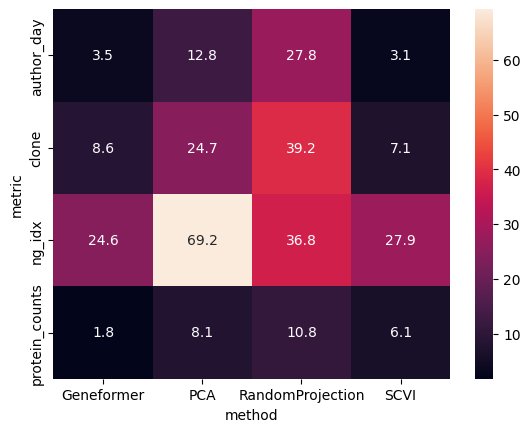

In [9]:
noise_proj = pd.DataFrame(noise_d)
print('mean projected increase')
print(noise_proj.groupby('method')['perc_increase'].mean())

# plot heatmap
sns.heatmap(pd.pivot_table(noise_proj, values='perc_increase', 
                           index='metric', columns='method'), annot=True, fmt=".1f")

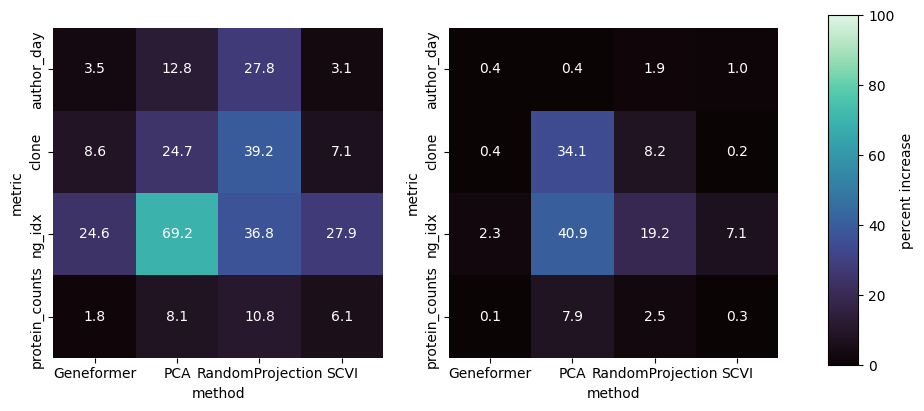

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(pd.pivot_table(noise_proj, values='perc_increase', 
                           index='metric', columns='method'), annot=True, fmt=".1f", ax=axes[0], square=True,
                           vmin=0, vmax=100, cmap="mako", cbar=False)

sns.heatmap(pd.pivot_table(projection_df, values='perc_increase', 
                           index='metric', columns='method'), annot=True, fmt=".1f", ax=axes[1], square=True,
                           vmin=0, vmax=100, cmap="mako", cbar=False)

# adjust layout to make room for color bar
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
norm = plt.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='percent increase')

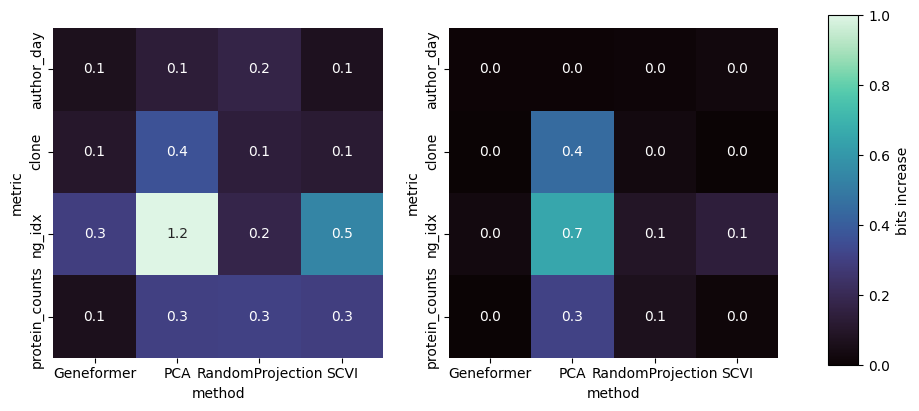

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(pd.pivot_table(noise_proj, values='bits increase', 
                           index='metric', columns='method'), annot=True, fmt=".1f", ax=axes[0], square=True,
                           vmin=0, vmax=1, cmap="mako", cbar=False)

sns.heatmap(pd.pivot_table(projection_df, values='bits increase', 
                           index='metric', columns='method'), annot=True, fmt=".1f", ax=axes[1], square=True,
                           vmin=0, vmax=1, cmap="mako", cbar=False)

# adjust layout to make room for color bar
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='bits increase')